# Сборный проект №2

## Описание проекта

Вы работаете в стартапе, который продаёт продукты питания. Нужно разобраться, как ведут себя пользователи вашего мобильного приложения. 

Изучите воронку продаж. Узнайте, как пользователи доходят до покупки. Сколько пользователей доходит до покупки, а сколько — «застревает» на предыдущих шагах? На каких именно?

После этого исследуйте результаты A/A/B-эксперимента. Дизайнеры захотели поменять шрифты во всём приложении, а менеджеры испугались, что пользователям будет непривычно. Договорились принять решение по результатам A/A/B-теста. Пользователей разбили на 3 группы: 2 контрольные со старыми шрифтами и одну экспериментальную — с новыми. Выясните, какой шрифт лучше.

Создание двух групп A вместо одной имеет определённые преимущества. Если две контрольные группы окажутся равны, вы можете быть уверены в точности проведенного тестирования. Если же между значениями A и A будут существенные различия, это поможет обнаружить факторы, которые привели к искажению результатов. Сравнение контрольных групп также помогает понять, сколько времени и данных потребуется для дальнейших тестов.

В случае общей аналитики и A/A/B-эксперимента работайте с одними и теми же данными. В реальных проектах всегда идут эксперименты. Аналитики исследуют качество работы приложения по общим данным, не учитывая принадлежность пользователей к экспериментам.

**Содержание работы**
- Описание данных
- Шаг 1. Откроем файл с данными и изучим общую информацию
- Шаг 2. Подготовим данные
- Шаг 3. Изучим и проверим данные
- Шаг 4. Изучим воронку событий
- Шаг 5. Изучим результаты эксперимента
- Итоговые выводы

## Описание данных

Каждая запись в логе — это действие пользователя, или событие.

- EventName — название события;
- DeviceIDHash — уникальный идентификатор пользователя;
- EventTimestamp — время события;
- ExpId — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная.

**Путь к файлу: /datasets/logs_exp.csv**

## Шаг 1. Откроем файл с данными и изучим общую информацию

In [1]:
#Импорт библиотек
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
import math as mth
from scipy import stats as st

In [2]:
#Объявимм переменную data и прочитаем файл
data = pd.read_csv('/datasets/logs_exp.csv', sep = '\t')
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


**Вывод**

- названия столбцов записанные некорректно, имеют заглавные буквы
- пропусков нет

## Шаг 2. Подготовим данные


In [3]:
#Заменим названия столбцов на удобные
data = data.rename(columns={'EventName':'event','DeviceIDHash':'device', 'EventTimestamp':'timestamp', 'ExpId':'group'})
data.head(2)

,event,device,timestamp,group
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246


In [4]:
#Проверим дубликаты
data.duplicated().sum()

413

In [5]:
# Удалим дубликаты
data = data.drop_duplicates()
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 243713 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   event      243713 non-null  object
 1   device     243713 non-null  int64 
 2   timestamp  243713 non-null  int64 
 3   group      243713 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 9.3+ MB


In [6]:
#Добавим столбец даты и времени, а также отдельный столбец дат
data['datetime'] = pd.to_datetime(data['timestamp'], unit='s')
data['date'] = data['datetime'].dt.date.astype('datetime64')
data.head(10)

,event,device,timestamp,group,datetime,date
0,MainScreenAppear,4575588528974610257,1564029816,246,2019-07-25 04:43:36,2019-07-25
1,MainScreenAppear,7416695313311560658,1564053102,246,2019-07-25 11:11:42,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
3,CartScreenAppear,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248,2019-07-25 11:48:42,2019-07-25
5,CartScreenAppear,6217807653094995999,1564055323,248,2019-07-25 11:48:43,2019-07-25
6,OffersScreenAppear,8351860793733343758,1564066242,246,2019-07-25 14:50:42,2019-07-25
7,MainScreenAppear,5682100281902512875,1564085677,246,2019-07-25 20:14:37,2019-07-25
8,MainScreenAppear,1850981295691852772,1564086702,247,2019-07-25 20:31:42,2019-07-25
9,MainScreenAppear,5407636962369102641,1564112112,246,2019-07-26 03:35:12,2019-07-26


In [7]:
devices = data['device'].nunique()
devices

7551

In [8]:
#проверим попадание пользователей в несколько групп одновременно
a_one= data.query('group == 246')['device'].nunique()
a_two= data.query('group == 247')['device'].nunique()
b_group= data.query('group == 248')['device'].nunique()
print('в группе "246" :', a_one, 'уникальных пользоватлей')
print('в группе "247" :', a_two, 'уникальных пользоватлей')
print('в группе "248" :', b_group, 'уникальных пользоватлей')
print('Всего:', a_one + a_two + b_group)

в группе "246" : 2489 уникальных пользоватлей
в группе "247" : 2520 уникальных пользоватлей
в группе "248" : 2542 уникальных пользоватлей
Всего: 7551


**Вывод**

- заменили названия столбцов
- удалили дубликаты, проверили пропуски
- добавили столбец даты и времени, также отдельный столбец для дат

- Сумма уникальных пользователей по группам совпадает с количеством уникальных пользователей во всём датасете, значит каждый пользователь находится только в одной группе.

## Шаг 3. Изучим и проверим данные


**1. Сколько всего событий в логе?**

In [9]:
#найдем количетво вариантов событий
print(len(data['event'].value_counts()))

5


In [10]:
#найдем количество событий в логе
print(len(data['event']))

243713


In [11]:
#посмотрим на количество событий каждого вида
data['event'].value_counts()

MainScreenAppear           119101
OffersScreenAppear          46808
CartScreenAppear            42668
PaymentScreenSuccessful     34118
Tutorial                     1018
Name: event, dtype: int64

**2. Сколько всего пользователей в логе?**

In [12]:
print(len(data['device'].value_counts()))

7551


**3. Сколько в среднем событий приходится на пользователя?**

In [13]:
data_events = data.pivot_table(index='device',values='event',aggfunc='count')
print(round(data_events['event'].mean(), 1))

32.3


In [14]:
#посмотрим распределение Кол-ва событий на пользователя:
event_per_user = data.groupby('device')['event'].count()
event_per_user.describe()

count    7551.000000
mean       32.275593
std        65.154219
min         1.000000
25%         9.000000
50%        20.000000
75%        37.000000
max      2307.000000
Name: event, dtype: float64

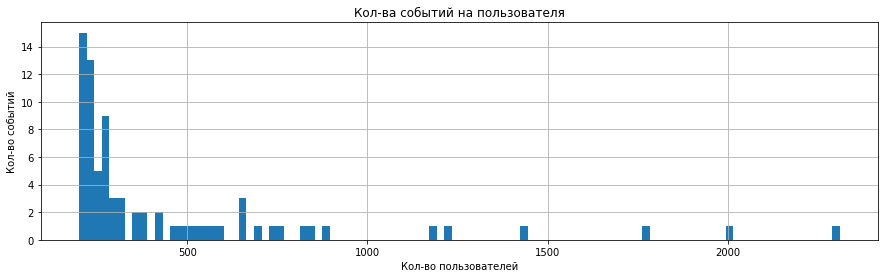

In [15]:
plt.figure(figsize=(15,4))
plt.hist(event_per_user, bins=100, range=(200,2310)) 
plt.xlabel('Кол-во пользователей')
plt.grid()
plt.ylabel('Кол-во событий')
plt.title('Кол-ва событий на пользователя')
plt.show()

Есть выбросы, которые искажают средний показатель. Рациональнее будет взять медианое значение, а именно 20.

Значит 20 событий приходится на пользователя

**4. Данными за какой период вы располагаете? Найдите максимальную и минимальную дату. Изучите, как меняется количество данных: постройте столбчатую диаграмму, которая отобразит количество событий в зависимости от времени в разрезе групп. Можно ли быть уверенным, что у вас одинаково полные данные за весь период? Технически в логи новых дней по некоторым пользователям могут «доезжать» события из прошлого — это может «перекашивать данные». Определите, с какого момента данные полные и отбросьте более старые. Данными за какой период времени вы располагаете на самом деле?**

In [16]:
print('Минимальная дата', data['date'].min())
print('Максимальная дата', data['date'].max())

Минимальная дата 2019-07-25 00:00:00
Максимальная дата 2019-08-07 00:00:00


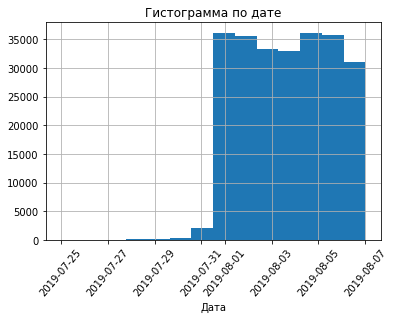

In [17]:
# Посмотрим гистограмму событий по дате
data['date'].hist(bins = 14).set_title('Гистограмма по дате')
plt.xlabel("Дата")
plt.xticks(rotation=50) 
plt.show()

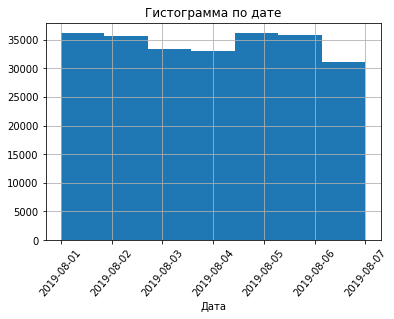

In [18]:
# Посмотрим гистограмму событий по дате, начиная с 01.08.2019
data['date'] = pd.to_datetime(data['date'])
data_new = data.query('date > "2019-07-31"')
data_new['date'].hist(bins = 7).set_title('Гистограмма по дате')
plt.xlabel("Дата")
plt.xticks(rotation=50) 
plt.show()

**Вывод**

До 01.08.2019 совершается очень мало событий - скорее всего, как раз с этой даты все данные доехали, а значит можно оценивать результаты экспериментов.

**5. Много ли событий и пользователей вы потеряли, отбросив старые данные?**

In [19]:
devices = len(data['device'].value_counts())
all_events = len(data['event'])

new_devices = data_new['device'].nunique()
print(f'Было пользователей = {devices} / Стало = {new_devices}')
print(f'Количество пользователей уменьшилось на {devices-new_devices}')
print(f'Потеря составила {round((devices-new_devices)/devices*100,2)}%')

new_events = data_new['event'].count()
print(f'Было событий = {all_events} / Стало = {new_events}')
print(f'Количество событий уменьшилось на {all_events-new_events}')
print(f'Потеря составила {round((all_events-new_events)/all_events*100,2)}%')

Было пользователей = 7551 / Стало = 7534
Количество пользователей уменьшилось на 17
Потеря составила 0.23%
Было событий = 243713 / Стало = 240887
Количество событий уменьшилось на 2826
Потеря составила 1.16%


**6. Проверьте, что у вас есть пользователи из всех трёх экспериментальных групп.**

In [20]:
data_new['group'].value_counts()

248    84563
246    79302
247    77022
Name: group, dtype: int64

На каждую группу приходится по 77-84к событий.

**Общий вывод**

В ходе проверки данных выяснилось, что данные предоставлены с 25 июля по 7 августа.

- Всего у нас 5 вариантов событий с общим количеством логов 243713
- Среднее кол-во событий пользователя равно 32, ноесть выбросы поэтому рациональней использовать медиану равную 20 
- Данные, которыми мы располагаем на самом деле, идут начиная с 01.08.2019
- При отсечении старых данных, были утеряны 2826 событий и 17 пользователей

## Шаг 4. Изучим воронку событий


**1. Посмотрите, какие события есть в логах, как часто они встречаются. Отсортируйте события по частоте.**

In [21]:
#События в порядке убывания повторяемости
data['event'].value_counts()

MainScreenAppear           119101
OffersScreenAppear          46808
CartScreenAppear            42668
PaymentScreenSuccessful     34118
Tutorial                     1018
Name: event, dtype: int64

**2. Посчитайте, сколько пользователей совершали каждое из этих событий. Отсортируйте события по числу пользователей. Посчитайте долю пользователей, которые хоть раз совершали событие.**

In [22]:
events_users = data_new.groupby('event').agg({'event':'count', 'device':'nunique'}).sort_values(by='device', ascending=False)
events_users.drop(['Tutorial'], inplace=True)
events_users.columns = ['n_events', 'device']
events_users = events_users.reset_index()
events_users['users_event'] = (events_users['device'] / (data_new['device'].nunique()) * 100).round(1) # доля хотя бы раз совершивших событие
events_users

,event,n_events,device,users_event
0,MainScreenAppear,117328,7419,98.5
1,OffersScreenAppear,46333,4593,61.0
2,CartScreenAppear,42303,3734,49.6
3,PaymentScreenSuccessful,33918,3539,47.0


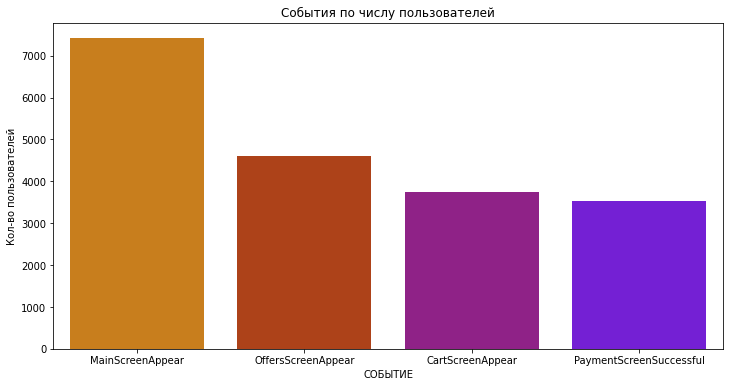

In [23]:
#построим график "События по числу пользователей"
plt.figure(figsize=(12,6))
sns.barplot(y='device', x='event', data=events_users, palette='gnuplot_r');
plt.xlabel('СОБЫТИЕ')
plt.ylabel('Кол-во пользователей')
plt.title('События по числу пользователей')
plt.show()

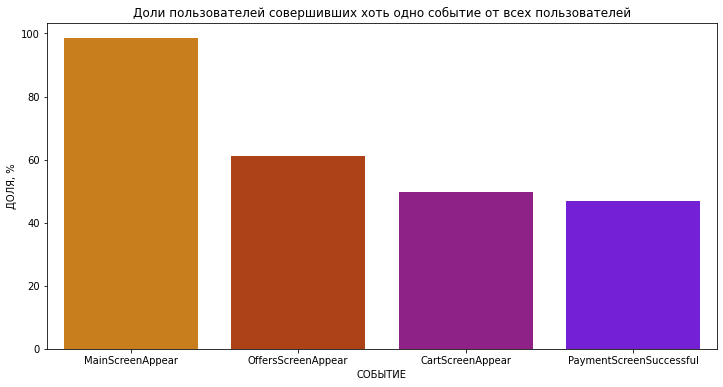

In [24]:
#построим график по долям пользователей
plt.figure(figsize=(12,6))
sns.barplot(y=('users_event'), x='event', data=events_users, palette='gnuplot_r');
plt.xlabel('СОБЫТИЕ')
plt.ylabel('ДОЛЯ, %')
plt.title('Доли пользователей совершивших хоть одно событие от всех пользователей')
plt.show()

**Вывод**

Судя по всему, события складываются в воронку продаж. Самое популярное событие - показ главного экрана, а самое непопулярное - экран оплаты, не учитывая показ руководства пользователя

**3. Предположите, в каком порядке происходят события. Все ли они выстраиваются в последовательную цепочку? Их не нужно учитывать при расчёте воронки.**

Воронка выглядит следующим образом:
1. MainScreenAppear - Появление Главного экрана - Зашли на сайт
2. OffersScreenAppear - Появление Экрана Предложений - Искали товар по каталогу
3. CartScreenAppear - Появление Экрана Корзины - Добавили в корзину
4. PaymentScreenSuccessful - Экран Платеж Успешен - Оплатили


**4. По воронке событий посчитайте, какая доля пользователей проходит на следующий шаг воронки (от числа пользователей на предыдущем). То есть для последовательности событий A → B → C посчитайте отношение числа пользователей с событием B к количеству пользователей с событием A, а также отношение числа пользователей с событием C к количеству пользователей с событием B.**

In [25]:
#Создадим столбец конверсий и рассчитаем их в цикле
events_users['conversion'] = 0
for i in range(0, len(events_users['users_event'] )):
    if i == 0:
        events_users['conversion'].iloc[i] = 100
    else:
        events_users['conversion'].iloc[i] = round(int(events_users['device'].iloc[i]) / int(events_users['device'].iloc[i-1]), 2)*100
display(events_users)

/opt/conda/lib/python3.9/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


,event,n_events,device,users_event,conversion
0,MainScreenAppear,117328,7419,98.5,100
1,OffersScreenAppear,46333,4593,61.0,62
2,CartScreenAppear,42303,3734,49.6,81
3,PaymentScreenSuccessful,33918,3539,47.0,95


**Вывод**

Было подсчитано, какой процент пользователей проходит на каждый из этапов воронки, от предыдущего шага. На экран с предложением проходит 62% пользователей, посмотревших главный экран. На экран с корзиной переходит 81% пользователей. На экран с успешной оплатой переходит 95% пользователей.

**5. На каком шаге теряете больше всего пользователей?**

К оплате переходит 95% пользователей от предыдущего шага, а вот к экрану с предложением проходит только 62% пользователей. Возможно, главный экран сайта не самый удобный для пользователей, или имеются другие проблемы. Наименее популярным событием в воронке продаж - событие перехода к оплате. Но если смотреть на конверсию, то большой процент пользователей теряется при переходе от главного экрана к экрану с предложением.

Больше всего пользователей теряется на шаге "OffersScreenAppear". Событие "Tutorial" не несет полезной нагрузки, поэтому его можно не принимать во внимание.

**6. Какая доля пользователей доходит от первого события до оплаты?**

In [26]:
print(round(events_users['device'].iloc[3]/events_users['device'].iloc[0], 2)*100)

48.0


До оплаты доходит 48% пользователей

**Общий вывод:**

Воронка продаж идет по следующему порядку:

1. MainScreenAppear - Появление Главного экрана - Зашли на сайт
2. OffersScreenAppear - Появление Экрана Предложений - Искали товар по каталогу
3. CartScreenAppear - Появление Экрана Корзины - Добавили в корзину
4. PaymentScreenSuccessful - Экран Платеж Успешен - Оплатили

Больше всего пользователей теряется на шаге "OffersScreenAppear". Событие "Tutorial" не несет полезной нагрузки, поэтому его можно не принимать во внимание.

До оплаты "PaymentScreenSuccessful" доходит 48% пользователей.

## Шаг 5. Изучим результаты эксперимента

**1. Сколько пользователей в каждой экспериментальной группе?**

In [27]:
# проверим сколько пользователей в каждой группе
new_data_groups = (
    data_new
    .groupby('group')
    .agg({'device': 'nunique'})
    .reset_index()
    .rename(columns={'device':'users'})
)
new_data_groups

,group,users
0,246,2484
1,247,2513
2,248,2537


**Вывод**

- В 246 группе 2484 пользователя
- В 247 группе 2513 пользователей
- В 248 группе 2537 пользователей

**2. Есть 2 контрольные группы для А/А-эксперимента, чтобы проверить корректность всех механизмов и расчётов. Проверьте, находят ли статистические критерии разницу между выборками 246 и 247.**

**3.  Выберите самое популярное событие. Посчитайте число пользователей, совершивших это событие в каждой из контрольных групп. Посчитайте долю пользователей, совершивших это событие. Проверьте, будет ли отличие между группами статистически достоверным. Проделайте то же самое для всех других событий (удобно обернуть проверку в отдельную функцию). Можно ли сказать, что разбиение на группы работает корректно?**

**4. Аналогично поступите с группой с изменённым шрифтом. Сравните результаты с каждой из контрольных групп в отдельности по каждому событию. Сравните результаты с объединённой контрольной группой. Какие выводы из эксперимента можно сделать?**

In [28]:
# Проверим находят ли статистические критерии разницу между выборками 246 и 247
users_by_events = (
data_new
    .pivot_table(index = 'group',
                 columns = 'event',
                 values = 'device',
                 aggfunc = 'nunique')
    .reset_index()
)

#и добавим столбец с количеством пользователей в группах
users_by_events['users'] = new_data_groups['users']

users_by_events

event,group,CartScreenAppear,MainScreenAppear,OffersScreenAppear,PaymentScreenSuccessful,Tutorial,users
0,246,1266,2450,1542,1200,278,2484
1,247,1238,2476,1520,1158,283,2513
2,248,1230,2493,1531,1181,279,2537


Cравним доли оплативших заказ клиентов групп 246 и 247:
- из 2484 пользователей группы 246, заказ оплатили 1200 человек
- из 2513 пользователей группы 247 заказ оплатили 1158. 

Попробуем сделать вывод о разнице в конверсии для этих групп.

In [29]:
# формирование вспомогательной функции для вывода результатов теста
def test_result(value_1, value_2):
    if value_1 < value_2:
        print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
    else:
        print('Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными')
        
def hypo_test (trials_1, trials_2, successes_1, successes_2, alpha):
    
    p1 = successes_1/trials_1
    p2 = successes_2/trials_2
    p_combined = (successes_1 + successes_2) / (trials_1 + trials_2)

    difference = p1 - p2 
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1 / trials_1 + 1 / trials_2))
    distr = st.norm(0, 1)

    p_value = (1 - distr.cdf(abs(z_value))) * 2
    
    pr_1 = print('p-значение: ', p_value)
    
    pr_2 = test_result(p_value, alpha)
    
    return pr_1, pr_2

Сформулируем гипотезы:

- Нулева гипотеза - различий в долях клиентов, оплативших заказ между группами нет
- Альтернативная гипотеза - различия в долях клиентов, оплативших заказ между группами есть.

Уровень статистической значимости = 0.05.

Проверяем гипотезы с помощью z-test

In [30]:
print('Проверка гипотезы о различиях в долях клиентов по событию', 
      users_by_events.columns[4], 'в группах 246 и 247')
hypo_test (users_by_events.iloc[0,6],
           users_by_events.iloc[1,6],
           users_by_events.iloc[0,4],
           users_by_events.iloc[1,4], 0.05)

Проверка гипотезы о различиях в долях клиентов по событию PaymentScreenSuccessful в группах 246 и 247
p-значение:  0.11456679313141849
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


(None, None)

**Вывод**

Cтатистически значимых различий между двумя А-группами не обнаружено.

**Посчитаем доли от общего количества пользователей по группа. Выберем самое популярное событие - MainScreenAppear.**

In [31]:
# формирование вспомогательной таблицы
top_event = users_by_events[['group', 'MainScreenAppear', 'users']].copy()
top_event['share'] = round(top_event['MainScreenAppear'] / top_event['users'], 3)
top_event

event,group,MainScreenAppear,users,share
0,246,2450,2484,0.986
1,247,2476,2513,0.985
2,248,2493,2537,0.983


98-99% пользователей в каждой из групп проходили через главный экран приложения.

In [32]:
#Проверим, будет ли отличие между группами 246 и 247 статистически достоверным.
print('Проверка гипотезы о различиях в долях клиентов по событию', 
      users_by_events.columns[2], 'в группах 246 и 247')
hypo_test (users_by_events.iloc[0,6], 
           users_by_events.iloc[1,6], 
           users_by_events.iloc[0,2], 
           users_by_events.iloc[1,2], 0.05)

Проверка гипотезы о различиях в долях клиентов по событию MainScreenAppear в группах 246 и 247
p-значение:  0.7570597232046099
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


(None, None)

**Вывод**

Cтатистически значимых различий между группами 246 и 247 по результатам проверки различий в долях клиентов, взаимодействующих с главным экраном, не обнаружено.

In [33]:
#Проведем проверку по остальным событиям: OffersScreenAppear, CartScreenAppear и Tutorial.

# пробежимся циклом по листу с событиями
column_list = [3, 1, 5]
for column_number in column_list:
    print('**Проверка гипотезы о различиях в долях клиентов по событию', 
      users_by_events.columns[column_number], 'в группах 246 и 247')
    hypo_test (users_by_events.iloc[0,6],
               users_by_events.iloc[1,6],
               users_by_events.iloc[0,column_number],
               users_by_events.iloc[1,column_number], 0.05)
    print('\n')

**Проверка гипотезы о различиях в долях клиентов по событию OffersScreenAppear в группах 246 и 247
p-значение:  0.2480954578522181
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


**Проверка гипотезы о различиях в долях клиентов по событию CartScreenAppear в группах 246 и 247
p-значение:  0.22883372237997213
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


**Проверка гипотезы о различиях в долях клиентов по событию Tutorial в группах 246 и 247
p-значение:  0.9376996189257114
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными




**Вывод**

По результатам проверок видно, что статистически значимых различий между группами 246 и 247 нет и группы разбиты корректно.

In [34]:
# Сравним результаты группы 248 с каждой из групп 246 и 247 в отдельности по каждому событию

column_list = [2, 3, 1, 4, 5]
for column_number in column_list:
    print('Проверка гипотезы о различиях в долях клиентов по событию', 
      users_by_events.columns[column_number], 'в группах 246 и 248')
    hypo_test (users_by_events.iloc[0,6],
               users_by_events.iloc[2,6],
               users_by_events.iloc[0,column_number],
               users_by_events.iloc[2,column_number], 0.05)
    print('\n')
    print('Проверка гипотезы о различиях в долях клиентов по событию', 
      users_by_events.columns[column_number], 'в группах 247 и 248')
    hypo_test (users_by_events.iloc[1,6],
               users_by_events.iloc[2,6],
               users_by_events.iloc[1,column_number],
               users_by_events.iloc[2,column_number], 0.05)
    print('\n')
    print('\n')

Проверка гипотезы о различиях в долях клиентов по событию MainScreenAppear в группах 246 и 248
p-значение:  0.2949721933554552
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Проверка гипотезы о различиях в долях клиентов по событию MainScreenAppear в группах 247 и 248
p-значение:  0.4587053616621515
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными




Проверка гипотезы о различиях в долях клиентов по событию OffersScreenAppear в группах 246 и 248
p-значение:  0.20836205402738917
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Проверка гипотезы о различиях в долях клиентов по событию OffersScreenAppear в группах 247 и 248
p-значение:  0.9197817830592261
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными




Проверка гипотезы о различиях в долях клиентов по событию CartScreenAppear в группах 246 и 248
p-значение:  0.07842923237520116
Не получилось отвергнуть нулевую ги

**Вывод:**

По результатам проверок видно, что статистически значимых различий между группами 246, 247 и 248 нет.

In [35]:
# Добавим в таблицу users_by_events строку с данными по объединённой контрольной группе 246_247 
#для сравнения результатов с группой 248
row_246_247 = users_by_events.loc[0] + users_by_events.loc[1]
users_all = users_by_events.copy()
users_all = users_all.append([row_246_247]).reset_index(drop=True)
users_all.iloc[3,0] = '246, 247'
users_all

event,group,CartScreenAppear,MainScreenAppear,OffersScreenAppear,PaymentScreenSuccessful,Tutorial,users
0,246,1266,2450,1542,1200,278,2484
1,247,1238,2476,1520,1158,283,2513
2,248,1230,2493,1531,1181,279,2537
3,"246, 247",2504,4926,3062,2358,561,4997


In [36]:
# Сравним результаты группы 248 с объединённой контрольной группой 246, 247 в отдельности по каждому событию
column_list = [2, 3, 1, 4, 5]
for column_number in column_list:
    print('**Проверка гипотезы о различиях в долях клиентов по событию', 
      users_all.columns[column_number], 'в группах 246, 247 и 248**')
    hypo_test (users_all.iloc[3,6],
               users_all.iloc[2,6],
               users_all.iloc[3,column_number],
               users_all.iloc[2,column_number], 0.05)
    print('\n')

**Проверка гипотезы о различиях в долях клиентов по событию MainScreenAppear в группах 246, 247 и 248**
p-значение:  0.29424526837179577
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


**Проверка гипотезы о различиях в долях клиентов по событию OffersScreenAppear в группах 246, 247 и 248**
p-значение:  0.43425549655188256
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


**Проверка гипотезы о различиях в долях клиентов по событию CartScreenAppear в группах 246, 247 и 248**
p-значение:  0.18175875284404386
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


**Проверка гипотезы о различиях в долях клиентов по событию PaymentScreenSuccessful в группах 246, 247 и 248**
p-значение:  0.6004294282308704
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


**Проверка гипотезы о различиях в долях клиентов по событию Tutorial в группах 246, 247 и 248**
p-значение:  0.7648624725315

**Вывод:**

По результатам проверок можно сделать общий вывод, что статистически значимых различий между группами 246, 247 и 248 также нет. Замена шрифта не повлияла на пользователей.

**5. Какой уровень значимости вы выбрали при проверке статистических гипотез выше? Посчитайте, сколько проверок статистических гипотез вы сделали. При уровне значимости 0.1 в 10% случаев можно ошибочно отклонить нулевую гипотезу при условии, что она верна. Какой уровень значимости стоит применить? Если вы хотите изменить его, проделайте предыдущие пункты и проверьте свои выводы.**

При проверке статистических гипотез выше мы выбрали уровень значимости равный 0.05. Посчитаем, сколько проверок статистических гипотез мы сделали. Мы провели множественный тест, т.е. брали несколько выборок из одного и того же набора данных. Его особенность в том, что с каждой новой проверкой гипотезы растёт вероятность ошибки первого рода. При уровне значимости 0.1 каждый десятый раз можно получать ложный результат.

In [37]:
#сколько проверок статистических гипотез мы сделали
count = len(users_all['group'].unique()) * len(data_new['event'].unique())
print(count)

20


In [38]:
p_value = 1 - (1 - 0.05)**(1 / count)
print('Уточненый p-value:', p_value)

Уточненый p-value: 0.0025613787765302876


**Вывод**

Результаты не изменятся, уточненный p-value получился еще меньше. Внесённые нами изменения никак не повлияли на метрики и на поведения пользователей. Поэтому смысла в их применении ко всему ресурсу нет - они не принесут никакой выгоды бизнесу.

## Итоговые выводы

**В датасете** обозначены столбцы с названием события, ID девайса пользователя, временем события и номером экспериментальной группы. Представлены следубщие события: MainScreenAppear, OffersScreenAppear, CartScreenAppear, PaymentScreenSuccessful, Tutorial. События являются частью воронки продаж на сайте. В ходе предобработки данных мы:
- заменили названия столбцов
- удалили дубликаты, проверили пропуски
- добавили столбец даты и времени, также отдельный столбец для дат

**В логе есть 5 событий**, по убыванию их популярности: показ пользователю главного экрана, показ экрана с предложением, показ экрана корзины, показ экрана с подтверждением оплаты, показ обучения. В логе всего 7551 пользователь. В среднем на пользователя приходится 32 события, однако это число завышено из за больших выбросов. Чаще всего на пользователей приходится 20 событий.

**До 01.08.201 совершается очень мало событий.** Скорее всего как раз с этой даты все данные доехали, и можно оценивать результаты экспериментов. После удаления ранних данных были потеряно 2826 событий, что составляет около 1% от общего числа, 6 пользователей.

По 77-84к событий приходится на каждую эксперименальную группу.

**Cобытия складываются в воронку продаж.** Самое популярное событие - показ главного экрана, а самое непопулярное, которое входит в воронку продаж, - показ экрана оплаты, не учитывая руководство пользования. Предположительно, воронка продаж следующая:
1. MainScreenAppear - Появление Главного экрана - Зашли на сайт
2. OffersScreenAppear - Появление Экрана Предложений - Искали товар по каталогу
3. CartScreenAppear - Появление Экрана Корзины - Добавили в корзину
4. PaymentScreenSuccessful - Экран Платеж Успешен - Оплатили
5. Tutorial - Руководство пользователя - Изучали инструкцию

**Было подсчитано, какой процент** пользователей проходит на каждый из этапов воронки, от предыдущего шага. На экран с предложением проходит 62% пользователей, посмотревших главный экран. На экран с корзиной переходит 81% пользователей. На экран с успешной оплатой переходит 95% пользователей. К оплате переходит 95% пользователей от предыдущего шага. На руководство пользования 24%. От первого события до оплаты доходит 48% пользователей.

**В 246 группе 2484 пользователя**, в 247 группе 2513 пользователей, в группе 248, с увеличенными шрифтами, 2537 пользователей. Как видно из проверги гипотез о равенстве долей, нет оснований считать контрольные выборки групп 246 и 247 разными.Самым популярным событием, как и ожидалось, становится показ главного экрана сайта. С этого и начинается воронка продаж.

**Исходя из результатов A/A/B-эксперимента**, можно сделать вывод, что изменение шрифта не оказало значимого эффекта на поведение пользователей - что можно считать успехом, так как целью было узнать не отпугнут ли изменения пользователей. В то же время учитывая результаты эксперимента, если изменение шрифта не продиктовано проблемами в работе приложения, его можно не менять.